In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
import os

In [3]:
from my_ds_kit import preprocessing as pp
from my_ds_kit import modeling as ml
from my_ds_kit import viz

from my_ds_kit.modeling.CvRegressor import CvRegressor

/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
os.listdir('input')

['weather_test.csv',
 'weather_train.csv',
 'test.csv',
 'train.csv',
 'building_metadata.csv',
 'sample_submission.csv']

In [ ]:
train = pd.read_pickle('inter/merge_train.pkl')
test = pd.read_pickle('inter/merge_test.pkl')

In [ ]:
train[train.floor_count.isna()].head()

# Feature Engineering

In [ ]:
train['primary_use_vs_meter'] = train['primary_use'].str.cat(train['meter'].astype(str), sep='_', na_rep='NA')
test['primary_use_vs_meter'] = test['primary_use'].str.cat(test['meter'].astype(str), sep='_', na_rep='NA')

In [ ]:
train['primary_use_vs_year_built'] = train['primary_use'].str.cat(train['year_built'].astype(str), sep='_', na_rep='NA')
test['primary_use_vs_year_built'] = test['primary_use'].str.cat(test['year_built'].astype(str), sep='_', na_rep='NA')

## no_of_years

In [ ]:
train['no_of_years'] = train['year'] - train['year_built']
test['no_of_years'] = test['year'] - test['year_built']

## dow vs hour

In [ ]:
train['dow_hour'] = train['dow'].astype('int16') * 100 + train['hour']
test['dow_hour'] = test['dow'].astype('int16') * 100 + test['hour']

In [ ]:
train.head(1000)

## year_built vs meter

In [ ]:
train['year_built_meter'] = train['year_built'] * 10 + train['meter']
test['year_built_meter'] = test['year_built'] * 10 + test['meter']

In [ ]:
train.head()

## site_id vs wind_direction

In [ ]:
train['site_id_wind_direction'] = (train['site_id'].astype('int32') + 100) * 1000 + train['wind_direction']
test['site_id_wind_direction'] = (test['site_id'].astype('int32') + 100) * 1000 + test['wind_direction']

In [ ]:
train.head()

## is_under_construction

In [ ]:
train['is_under_construction'] = (train['year'] == train['year_built']).astype(int)
test['is_under_construction'] = (test['year'] == test['year_built']).astype(int)

In [ ]:
train.to_pickle('for_modeling/train.pkl')
test.to_pickle('for_modeling/test.pkl')

# Reload data, transform and training

In [7]:
train = pd.read_pickle('for_modeling/train.pkl')
test = pd.read_pickle('for_modeling/test.pkl')

In [8]:
train.head()

,building_id,meter,timestamp,meter_reading,datetime,year,month,day,hour,dow,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,primary_use_vs_meter,primary_use_vs_year_built,no_of_years,dow_hour,year_built_meter,site_id_wind_direction,is_under_construction
0,0,0,1.451606e+09,0.0,2016-01-01,2016,1,1,0,4,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Education_0,Education_2008.0,8.0,400,20080.0,100000.0,0
1,1,0,1.451606e+09,0.0,2016-01-01,2016,1,1,0,4,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Education_0,Education_2004.0,12.0,400,20032.0,100000.0,0
2,2,0,1.451606e+09,0.0,2016-01-01,2016,1,1,0,4,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Education_0,Education_1991.0,25.0,400,19904.0,100000.0,0
3,3,0,1.451606e+09,0.0,2016-01-01,2016,1,1,0,4,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Education_0,Education_2002.0,14.0,400,20016.0,100000.0,0
4,4,0,1.451606e+09,0.0,2016-01-01,2016,1,1,0,4,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Education_0,Education_1975.0,41.0,400,19744.0,100000.0,0


# Categorical Transformation 

In [9]:
from sklearn.preprocessing import LabelEncoder
cat_cols = ['primary_use',
            'primary_use_vs_meter',
            'primary_use_vs_year_built']

for cat_col in cat_cols:
    print(cat_col)
    enc = LabelEncoder().fit(np.concatenate([train[cat_col], test[cat_col]], axis=0))
    train['lbl_'+cat_col] = enc.transform(train[cat_col])
    test['lbl_'+cat_col] = enc.transform(test[cat_col])

primary_use
primary_use_vs_meter
primary_use_vs_year_built


In [10]:

def target_encode(train, test, cat_cols):
    for cat_col in cat_cols:
        train['tgt_'+cat_col] = train.groupby(cat_col)['meter_reading'].transform('mean')
        test = test.merge(train[['tgt_'+cat_col, cat_col]].drop_duplicates(), 
                          on=cat_col,
                          how='left')
    return train, test

In [11]:
# cat_cols = ['primary_use',
#             'primary_use_vs_meter',
#             'primary_use_vs_year_built',
#             'month',
#             'day',
#             'hour',
#             'dow',
#             'site_id',
#             'dow_hour',
#             'year_built_meter',
#             'site_id_wind_direction']

# for cat_col in cat_cols:
#     print(cat_col)
#     train['tgt_'+cat_col] = train.groupby(cat_col)['meter_reading'].transform('mean')
#     test = test.merge(train[['tgt_'+cat_col, cat_col]].drop_duplicates(), 
#                       on=cat_col,
#                       how='left')

In [12]:
train.head()

,building_id,meter,timestamp,meter_reading,datetime,year,month,day,hour,dow,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,primary_use_vs_meter,primary_use_vs_year_built,no_of_years,dow_hour,year_built_meter,site_id_wind_direction,is_under_construction,lbl_primary_use,lbl_primary_use_vs_meter,lbl_primary_use_vs_year_built
0,0,0,1.451606e+09,0.0,2016-01-01,2016,1,1,0,4,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Education_0,Education_2008.0,8.0,400,20080.0,100000.0,0,0,0,90
1,1,0,1.451606e+09,0.0,2016-01-01,2016,1,1,0,4,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Education_0,Education_2004.0,12.0,400,20032.0,100000.0,0,0,0,86
2,2,0,1.451606e+09,0.0,2016-01-01,2016,1,1,0,4,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Education_0,Education_1991.0,25.0,400,19904.0,100000.0,0,0,0,74
3,3,0,1.451606e+09,0.0,2016-01-01,2016,1,1,0,4,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Education_0,Education_2002.0,14.0,400,20016.0,100000.0,0,0,0,84
4,4,0,1.451606e+09,0.0,2016-01-01,2016,1,1,0,4,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Education_0,Education_1975.0,41.0,400,19744.0,100000.0,0,0,0,61


In [13]:
from matplotlib import pyplot as plt

In [14]:
train = train.sort_values('timestamp')

In [15]:
train.reset_index(drop=True, inplace=True)

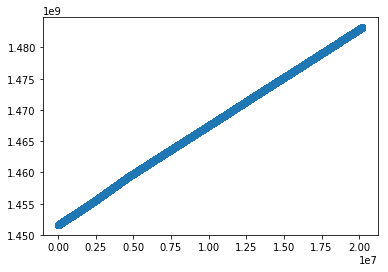

In [16]:
_ = plt.scatter(x=train.index, y=train.timestamp)

# Training

## Training with all data

In [17]:
train_len = len(train) // 2

first = train.loc[range(train_len),:]
second = train.loc[range(train_len, len(train)),:]

cat_cols = ['primary_use',
            'primary_use_vs_meter',
            'primary_use_vs_year_built',
            'month',
            'day',
            'hour',
            'dow',
            'site_id',
            'dow_hour',
            'year_built_meter',
            'site_id_wind_direction']

for cat_col in cat_cols:
    print(cat_col)
    first['tgt_'+cat_col] = first.groupby(cat_col)['meter_reading'].transform('mean')
    second = second.merge(first[['tgt_'+cat_col, cat_col]].drop_duplicates(), 
                      on=cat_col,
                      how='left')

primary_use
primary_use_vs_meter
primary_use_vs_year_built
month
day
hour
dow
site_id
dow_hour
year_built_meter
site_id_wind_direction


In [18]:
import pandas as pd

In [19]:
train = pd.concat([first, second])

In [20]:
tgt_cols = ['tgt_primary_use', 
      'tgt_primary_use_vs_meter', 
      'tgt_primary_use_vs_year_built', 
      'tgt_month',
      'tgt_day',
      'tgt_hour',
      'tgt_dow',
      'tgt_dow_hour',
      'tgt_year_built_meter',
      'tgt_site_id_wind_direction']

for tgt_col in tgt_cols:
    train[train[tgt_col].isin([np.inf, -np.inf])][tgt_col] = np.nan

In [21]:
train.head()

,building_id,meter,timestamp,meter_reading,datetime,year,month,day,hour,dow,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,primary_use_vs_meter,primary_use_vs_year_built,no_of_years,dow_hour,year_built_meter,site_id_wind_direction,is_under_construction,lbl_primary_use,lbl_primary_use_vs_meter,lbl_primary_use_vs_year_built,tgt_primary_use,tgt_primary_use_vs_meter,tgt_primary_use_vs_year_built,tgt_month,tgt_day,tgt_hour,tgt_dow,tgt_site_id,tgt_dow_hour,tgt_year_built_meter,tgt_site_id_wind_direction
0,0,0,1.451606e+09,0.000000,2016-01-01,2016,1,1,0,4,0,Education,7432,2008.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,Education_0,Education_2008.0,8.0,400,20080.0,100000.0,0,0,0,90,8475.679688,230.206985,243.179779,1150.157959,2710.920898,3586.985596,3769.311035,354.961578,3636.998779,144.284424,428.263275
1,1104,1,1.451606e+09,0.000000,2016-01-01,2016,1,1,0,4,13,Public services,199722,NaN,NaN,-8.296875,8.0,-12.203125,NaN,1023.5,250.0,4.101562,Public services_1,Public services_nan,NaN,400,NaN,113250.0,0,9,34,320,295.976898,461.706787,362.374451,1150.157959,2710.920898,3586.985596,3769.311035,25053.695312,3636.998779,NaN,27550.572266
2,1104,0,1.451606e+09,142.341003,2016-01-01,2016,1,1,0,4,13,Public services,199722,NaN,NaN,-8.296875,8.0,-12.203125,NaN,1023.5,250.0,4.101562,Public services_0,Public services_nan,NaN,400,NaN,113250.0,0,9,33,320,295.976898,95.421173,362.374451,1150.157959,2710.920898,3586.985596,3769.311035,25053.695312,3636.998779,NaN,27550.572266
3,1103,0,1.451606e+09,43.320999,2016-01-01,2016,1,1,0,4,13,Other,23903,NaN,NaN,-8.296875,8.0,-12.203125,NaN,1023.5,250.0,4.101562,Other_0,Other_nan,NaN,400,NaN,113250.0,0,7,27,268,121.778488,47.100216,59.591755,1150.157959,2710.920898,3586.985596,3769.311035,25053.695312,3636.998779,NaN,27550.572266
4,1102,2,1.451606e+09,3234.379883,2016-01-01,2016,1,1,0,4,13,Office,87187,NaN,NaN,-8.296875,8.0,-12.203125,NaN,1023.5,250.0,4.101562,Office_2,Office_nan,NaN,400,NaN,113250.0,0,6,25,261,522.566406,2395.940430,624.398987,1150.157959,2710.920898,3586.985596,3769.311035,25053.695312,3636.998779,NaN,27550.572266


In [22]:
train_len

10108050

In [48]:
from my_ds_kit.metrics.regression import rmsle

features = [x for x in train.columns if x not in ['building_id', 
                                                  'datetime',
                                                  'year',
                                                  'meter_reading', 
                                                  'timestamp',
                                                  'primary_use',
                                                  'primary_use_vs_meter',
                                                  'primary_use_vs_year_built']]
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "eval_metric": lambda y, y_pred: ('rmsle',rmsle(y, y_pred), False),
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          'metric': 'None'}



cv_reg = CvRegressor(folds=[(range(train_len), range(train_len,len(train)))],
                    algo='lgbm',
                    columns = features,
                    n_estimators=2000,
                    early_stopping_rounds=200,
                    grow_policy='lossguide',
                    **params)


best_score = cv_reg.fit(train.loc[:,features],
                       train.loc[:,'meter_reading'],
                       validate_train_set=False,
                       verbose=100)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmsle: 2.53494
[200]	valid_0's rmsle: 1.97303
[300]	valid_0's rmsle: 1.9097
[400]	valid_0's rmsle: 1.92969
[500]	valid_0's rmsle: 1.9536
Early stopping, best iteration is:
[325]	valid_0's rmsle: 1.90158


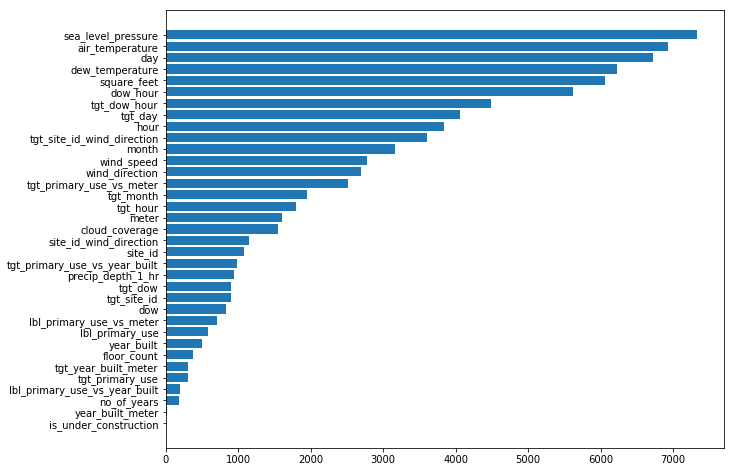

In [49]:
viz.plotFeatureImportances(features, cv_reg.models)

In [50]:
from my_ds_kit.feature_selection.permutation_importance import permutation_importance

In [51]:
import gc
gc.collect()

14683

In [52]:
valid = train.iloc[range(train_len,len(train))]

In [53]:
len(valid)

10108050

In [54]:
len(train)

20216100

In [55]:
scores = permutation_importance(cv_reg, 
                                valid[features], 
                                valid['meter_reading'],
                                features, 
                                rmsle)

/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking


/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Usual stacking



/Users/tungpt/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [56]:
scores

{'meter': [2.097195586197468,
  2.096679632381566,
  2.0966190130479316,
  2.096855561371522,
  2.096832185847372],
 'month': [1.901577887817201,
  1.901577887817201,
  1.901577887817201,
  1.901577887817201,
  1.901577887817201],
 'day': [1.902504647703998,
  1.9024031511999175,
  1.902065897346973,
  1.9023679115014132,
  1.9023724188494022],
 'hour': [1.9079346448042267,
  1.907619403183192,
  1.9076687358172502,
  1.9078560262460715,
  1.9079195889260092],
 'dow': [1.9021811931155845,
  1.9021030609332144,
  1.9021221614847499,
  1.9021537949539133,
  1.902206940074776],
 'site_id': [2.012356639037271,
  2.0119307627641447,
  2.012283666338687,
  2.012226285191755,
  2.0120910194629236],
 'square_feet': [2.342199840573686,
  2.342058613028089,
  2.3428447315744703,
  2.3424702377104967,
  2.3423109003925386],
 'year_built': [1.9186837147471694,
  1.918714367152174,
  1.9187114405040366,
  1.9186684648706736,
  1.9187642537640064],
 'floor_count': [1.9228083301347965,
  1.9229137054

In [19]:
excluded = ['tgt_month','month', 'tgt_day', 'is_under_construction']

## Retrain with noisy features removed

In [58]:
from my_ds_kit.metrics.regression import rmsle

features = [x for x in train.columns if x not in ['building_id', 
                                                  'datetime',
                                                  'year',
                                                  'meter_reading', 
                                                  'timestamp',
                                                  'primary_use',
                                                  'primary_use_vs_meter',
                                                  'primary_use_vs_year_built'] + excluded]

params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "eval_metric": lambda y, y_pred: ('rmsle',rmsle(y, y_pred), False),
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          'metric': 'None'}



cv_reg = CvRegressor(folds=[(range(train_len), range(train_len,len(train)))],
                    algo='lgbm',
                    columns = features,
                    n_estimators=2000,
                    early_stopping_rounds=200,
                    grow_policy='lossguide',
                    **params)


best_score = cv_reg.fit(train.loc[:,features],
                       train.loc[:,'meter_reading'],
                       validate_train_set=False,
                       verbose=100)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmsle: 2.5654
[200]	valid_0's rmsle: 2.0743
[300]	valid_0's rmsle: 1.9693
[400]	valid_0's rmsle: 1.94874
[500]	valid_0's rmsle: 1.95067
[600]	valid_0's rmsle: 1.9359
[700]	valid_0's rmsle: 1.93496
[800]	valid_0's rmsle: 1.9397
Early stopping, best iteration is:
[650]	valid_0's rmsle: 1.93245


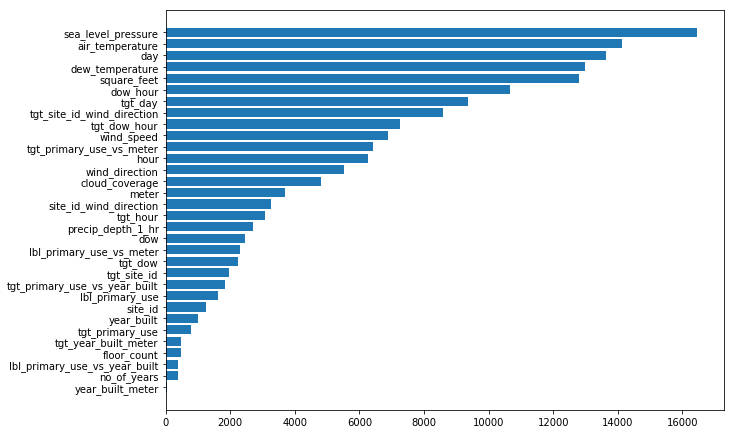

In [59]:
viz.plotFeatureImportances(features, cv_reg.models)

# Retrain actual model

In [10]:
cat_cols = ['primary_use',
            'primary_use_vs_meter',
            'primary_use_vs_year_built',
            'month',
            'day',
            'hour',
            'dow',
            'site_id',
            'dow_hour',
            'year_built_meter',
            'site_id_wind_direction']

for cat_col in cat_cols:
    print(cat_col)
    train['tgt_'+cat_col] = train.groupby(cat_col)['meter_reading'].transform('mean')
    test = test.merge(train[['tgt_'+cat_col, cat_col]].drop_duplicates(), 
                      on=cat_col,
                      how='left')

primary_use
primary_use_vs_meter
primary_use_vs_year_built
month
day
hour
dow
site_id
dow_hour
year_built_meter
site_id_wind_direction


In [11]:
train = train.sort_values('timestamp')

In [12]:
train.reset_index(drop=True, inplace=True)

In [20]:
from my_ds_kit.metrics.regression import rmsle
from sklearn.model_selection import KFold

features = [x for x in train.columns if x not in ['building_id', 
                                                  'datetime',
                                                  'year',
                                                  'meter_reading', 
                                                  'timestamp',
                                                  'primary_use',
                                                  'primary_use_vs_meter',
                                                  'primary_use_vs_year_built'] + excluded]
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "eval_metric": lambda y, y_pred: ('rmsle',rmsle(y, y_pred), False),
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          'metric': 'None'}


folds = KFold(n_splits=5, shuffle=False).split(train)

cv_reg = CvRegressor(folds=folds,
                    algo='lgbm',
                    columns = features,
                    n_estimators=2000,
                    early_stopping_rounds=200,
                    grow_policy='lossguide',
                    **params)


best_score = cv_reg.fit(train.loc[:,features],
                       train.loc[:,'meter_reading'],
                       validate_train_set=False,
                       verbose=100)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmsle: 2.77118
[200]	valid_0's rmsle: 2.42201
[300]	valid_0's rmsle: 2.3265
[400]	valid_0's rmsle: 2.30415
[500]	valid_0's rmsle: 2.28678
[600]	valid_0's rmsle: 2.27533
[700]	valid_0's rmsle: 2.26123
[800]	valid_0's rmsle: 2.24573
[900]	valid_0's rmsle: 2.24594
[1000]	valid_0's rmsle: 2.24634
Early stopping, best iteration is:
[843]	valid_0's rmsle: 2.23908
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmsle: 2.57706
[200]	valid_0's rmsle: 2.32948
[300]	valid_0's rmsle: 2.21452
[400]	valid_0's rmsle: 2.17661
[500]	valid_0's rmsle: 2.15839
[600]	valid_0's rmsle: 2.14342
[700]	valid_0's rmsle: 2.13463
[800]	valid_0's rmsle: 2.11362
[900]	valid_0's rmsle: 2.10906
[1000]	valid_0's rmsle: 2.10364
[1100]	valid_0's rmsle: 2.09707
[1200]	valid_0's rmsle: 2.1013
[1300]	valid_0's rmsle: 2.09645
[1400]	valid_0's rmsle: 2.09513
[1500]	valid_0's rmsle: 2.09372
[1600]	valid_0's rmsle: 2.09

In [21]:
pred = cv_reg.predict(test[features], stacked=True)

Usual stacking


In [22]:
pred = np.clip(pred, 0, None)

In [23]:
test['meter_reading'] = pred

In [24]:
test.loc[:, ['row_id', 'meter_reading']].to_csv('submission/base_submission.csv', index=False)